In [1]:
import pandas as pd, geopandas as gpd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Open the data

In [2]:
%%time

# open .csv with all the years
final_df = pd.read_csv("Storico meteo/Processed_data/variables_all_years2.csv")

CPU times: total: 29.9 s
Wall time: 59.3 s


The information available are:

B10004: PRESSURE, PA
B11001: WIND DIRECTION, DEGREE
B11002: WIND SPEED, M/S
B12101: TEMPERATURE/DRY-BULB TEMPERATURE
B13003: RELATIVE HUMIDITY, %
B13011: TOTAL PRECIPITATION / TOTAL WATER EQUIVALENT, KG/M**2

## Check missing data and exploring the df

In [3]:
# Assuming that the DataFrame has a 'date' column containing datetime objects
# Make sure that the 'date' column is a datetime object:
final_df['date'] = pd.to_datetime(final_df['date'])

# Filter the DataFrame to include only the whole hours
hourly_data = final_df[final_df['date'].dt.minute == 0].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B10004', 'B11001', 'B11002', 'B12101', 'B13003', 'B13011_1_3600']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
df_hourly_data_clean = hourly_data[hourly_data[selected_columns].notna().all(axis=1)]

# Assuming your DataFrame is named 'final_df' and you want to remove columns 'B13011_1_900', 'B13011_1_86400' and 'B13011_1_1800'
df_hourly_data_clean = df_hourly_data_clean.drop(['B13011_1_900', 'B13011_1_86400', 'B13011_1_1800'], axis=1).reset_index(drop=True)

# Assuming your DataFrame is named 'final_df' and you want to change the name of the column 'old_column_name' to 'new_column_name'
df_hourly_data_clean = df_hourly_data_clean.rename(columns={'B13011_1_3600': 'B13011'})

# Create a "date" column of datetime type without the UTC timezone.
df_hourly_data_clean['date'] = pd.to_datetime(df_hourly_data_clean['date']).dt.tz_localize(None)

# Extract the year from the "date" column and create a new "year" column.
df_hourly_data_clean['year'] = df_hourly_data_clean['date'].dt.year

# Add a column with the name of the month
df_hourly_data_clean['month_name'] = df_hourly_data_clean['date'].dt.strftime('%B')

# Convert the 'B12101' column from Kelvin to Celsius
df_hourly_data_clean['B12101_C'] = df_hourly_data_clean['B12101'] - 273.15

In [4]:
# Itera attraverso la lista delle colonne e calcola la percentuale di valori NaN
for colonna in selected_columns:
    num_nan = hourly_data[colonna].isna().sum()
    percentuale_nan = (num_nan / len(hourly_data)) * 100
    print(f"Colonna '{colonna}' ha {num_nan} valori NaN, che corrispondono al {percentuale_nan:.2f}% del totale.")

Colonna 'B10004' ha 23020400 valori NaN, che corrispondono al 89.90% del totale.
Colonna 'B11001' ha 22649705 valori NaN, che corrispondono al 88.46% del totale.
Colonna 'B11002' ha 22684292 valori NaN, che corrispondono al 88.59% del totale.
Colonna 'B12101' ha 8699489 valori NaN, che corrispondono al 33.97% del totale.
Colonna 'B13003' ha 18928462 valori NaN, che corrispondono al 73.92% del totale.
Colonna 'B13011_1_3600' ha 1307709 valori NaN, che corrispondono al 5.11% del totale.


In [5]:
df_hourly_data_clean

,name,lon,lat,h_sea,h_bar,B10004,B11001,B11002,B12101,B13003,B13011,date,year,month_name,B12101_C
0,Reggio nell'Emilia urbana,44.69781,10.63370,72.0,72.0,101100.0,235.0,1.4,276.15,53.0,0.0,2012-01-01 00:00:00,2012,January,3.0
1,Reggio nell'Emilia urbana,44.69781,10.63370,72.0,72.0,101110.0,193.0,0.7,276.15,54.0,0.0,2012-01-01 01:00:00,2012,January,3.0
2,Reggio nell'Emilia urbana,44.69781,10.63370,72.0,72.0,101140.0,160.0,0.4,276.45,52.0,0.0,2012-01-01 02:00:00,2012,January,3.3
3,Reggio nell'Emilia urbana,44.69781,10.63370,72.0,72.0,101180.0,67.0,1.0,273.35,66.0,0.0,2012-01-01 03:00:00,2012,January,0.2
4,Reggio nell'Emilia urbana,44.69781,10.63370,72.0,72.0,101220.0,86.0,0.7,273.85,63.0,0.0,2012-01-01 04:00:00,2012,January,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681269,Martorano,44.16614,12.26798,25.0,29.0,101540.0,277.0,2.8,276.85,78.0,0.0,2021-01-09 23:00:00,2021,January,3.7
1681270,Martorano,44.16614,12.26798,25.0,29.0,101500.0,279.0,2.9,276.75,80.0,0.0,2021-01-10 00:00:00,2021,January,3.6
1681271,Martorano,44.16614,12.26798,25.0,29.0,101480.0,262.0,3.2,276.55,84.0,0.0,2021-01-10 01:00:00,2021,January,3.4
1681272,Martorano,44.16614,12.26798,25.0,29.0,101490.0,269.0,5.3,275.75,93.0,0.8,2021-01-10 02:00:00,2021,January,2.6


## Check for each variable how many rows I have without counting NaN values and how many stations are remaining

In [7]:
# Assuming that the DataFrame has a 'date' column containing datetime objects
# Make sure that the 'date' column is a datetime object:
final_df['date'] = pd.to_datetime(final_df['date'])

# Filter the DataFrame to include only the whole hours
hourly_data = final_df[final_df['date'].dt.minute == 0].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B10004']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
B10004_pressure = hourly_data[hourly_data[selected_columns].notna().all(axis=1)].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B11001', 'B11002']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
wind_data = hourly_data[hourly_data[selected_columns].notna().all(axis=1)].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B12101']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
B12101_temperature = hourly_data[hourly_data[selected_columns].notna().all(axis=1)].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B13003']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
B13003_humidity = hourly_data[hourly_data[selected_columns].notna().all(axis=1)].reset_index(drop=True)

# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B13011_1_3600']

# Filter the DataFrame only for rows where the selected columns do not contain NaN values
B13011_precipitation = hourly_data[hourly_data[selected_columns].notna().all(axis=1)].reset_index(drop=True)

In [8]:
# Crea una lista con le variabili e i loro dati
variables = [
    ("B10004_pressure", B10004_pressure),
    ("wind_data", wind_data),
    ("B12101_temperature", B12101_temperature),
    ("B13003_humidity", B13003_humidity),
    ("B13011_precipitation", B13011_precipitation)
]

# Itera attraverso la lista e stampa il nome della variabile, il totale del len e il numero di valori unici nella colonna 'name'
for variable_name, variable_data in variables:
    total_len = len(variable_data)
    unique_names = len(variable_data['name'].unique())
    print(f"Variabile: {variable_name}, Totale di len: {total_len}, Valori unici in 'name': {unique_names}")

Variabile: B10004_pressure, Totale di len: 2585498, Valori unici in 'name': 33
Variabile: wind_data, Totale di len: 2860835, Valori unici in 'name': 49
Variabile: B12101_temperature, Totale di len: 16906409, Valori unici in 'name': 231
Variabile: B13003_humidity, Totale di len: 6677436, Valori unici in 'name': 109
Variabile: B13011_precipitation, Totale di len: 24298189, Valori unici in 'name': 350


In [9]:
# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B10004', 'B11001', 'B11002', 'B12101', 'B13003', 'B13011_1_3600']

# Itera attraverso la lista delle colonne e calcola la percentuale di valori NaN
for colonna in selected_columns:
    num_nan = wind_data[colonna].isna().sum()
    percentuale_nan = (num_nan / len(hourly_data)) * 100
    print(f"Colonna '{colonna}' ha {num_nan} valori NaN, che corrispondono al {percentuale_nan:.2f}% del totale.")

Colonna 'B10004' ha 926127 valori NaN, che corrispondono al 3.62% del totale.
Colonna 'B11001' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B11002' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B12101' ha 26303 valori NaN, che corrispondono al 0.10% del totale.
Colonna 'B13003' ha 744894 valori NaN, che corrispondono al 2.91% del totale.
Colonna 'B13011_1_3600' ha 254836 valori NaN, che corrispondono al 1.00% del totale.


In [34]:
# Crea una copia del DataFrame originale
interpolated_data = wind_data.copy()

# Sostituisci i valori 'NaN' con NaN (valori numerici)
columns_to_interpolate = ['B10004', 'B12101', 'B13003', 'B13011_1_3600']
interpolated_data[columns_to_interpolate] = interpolated_data[columns_to_interpolate].replace('NaN', pd.NA)

# Converti le colonne numeriche in float
interpolated_data[columns_to_interpolate] = interpolated_data[columns_to_interpolate].astype(float)

# Crea un oggetto IterativeImputer
imputer = IterativeImputer(random_state=0)

# Applica l'imputazione iterativa solo alle colonne da predire
interpolated_data[columns_to_interpolate] = imputer.fit_transform(interpolated_data[columns_to_interpolate])

In [35]:
# Assuming your DataFrame is named 'final_df' and you want to remove columns 'B13011_1_900', 'B13011_1_86400' and 'B13011_1_1800'
interpolated_data = interpolated_data.drop(['B13011_1_900', 'B13011_1_86400', 'B13011_1_1800'], axis=1).reset_index(drop=True)

# Assuming your DataFrame is named 'final_df' and you want to change the name of the column 'old_column_name' to 'new_column_name'
interpolated_data = interpolated_data.rename(columns={'B13011_1_3600': 'B13011'})

# Extract the year from the "date" column and create a new "year" column.
interpolated_data['year'] = interpolated_data['date'].dt.year

# Add a column with the name of the month
interpolated_data['month_name'] = interpolated_data['date'].dt.strftime('%B')

# Convert the 'B12101' column from Kelvin to Celsius
interpolated_data['B12101_C'] = interpolated_data['B12101'] - 273.15

In [37]:
# Replace 'selected_columns' with the list of columns you want to consider
selected_columns = ['B10004', 'B11001', 'B11002', 'B12101', 'B13003', 'B13011', 'date']

# Itera attraverso la lista delle colonne e calcola la percentuale di valori NaN
for colonna in selected_columns:
    num_nan = interpolated_data[colonna].isna().sum()
    percentuale_nan = (num_nan / len(hourly_data)) * 100
    print(f"Colonna '{colonna}' ha {num_nan} valori NaN, che corrispondono al {percentuale_nan:.2f}% del totale.")

Colonna 'B10004' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B11001' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B11002' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B12101' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B13003' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'B13011' ha 0 valori NaN, che corrispondono al 0.00% del totale.
Colonna 'date' ha 0 valori NaN, che corrispondono al 0.00% del totale.


In [36]:
interpolated_data

,name,lon,lat,h_sea,h_bar,B10004,B11001,B11002,B12101,B13003,B13011,date,year,month_name,B12101_C
0,Colorno,44.94378,10.34959,29.0,29.0,98427.621220,244.0,1.9,270.55,87.000000,0.000000,2012-01-01 00:00:00+00:00,2012,January,-2.6
1,Colorno,44.94378,10.34959,29.0,29.0,98431.869231,292.0,0.3,271.05,84.000000,0.000000,2012-01-01 01:00:00+00:00,2012,January,-2.1
2,Colorno,44.94378,10.34959,29.0,29.0,98414.845201,44.0,0.9,270.35,87.000000,0.000000,2012-01-01 02:00:00+00:00,2012,January,-2.8
3,Colorno,44.94378,10.34959,29.0,29.0,98421.233210,114.0,1.3,270.45,87.000000,0.000000,2012-01-01 03:00:00+00:00,2012,January,-2.7
4,Colorno,44.94378,10.34959,29.0,29.0,98475.914610,153.0,0.0,270.15,95.000000,0.000000,2012-01-01 04:00:00+00:00,2012,January,-3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860830,Cesenatico porto,44.20645,12.40132,1.0,1.0,98993.283962,310.0,4.7,281.55,77.048417,0.124842,2021-01-31 19:00:00+00:00,2021,January,8.4
2860831,Cesenatico porto,44.20645,12.40132,1.0,1.0,99003.753637,309.0,4.3,281.75,76.758927,0.123831,2021-01-31 20:00:00+00:00,2021,January,8.6
2860832,Cesenatico porto,44.20645,12.40132,1.0,1.0,98961.874935,313.0,3.3,280.95,77.916887,0.127876,2021-01-31 21:00:00+00:00,2021,January,7.8
2860833,Cesenatico porto,44.20645,12.40132,1.0,1.0,98967.109773,303.0,4.9,281.05,77.772142,0.127371,2021-01-31 22:00:00+00:00,2021,January,7.9


## Georeference the data

In [39]:
# Filter the first element for 'lon', 'lat', and 'h_sea' for each unique value in the 'name' column
wind_data_stations = wind_data.groupby('name').agg({
    'lon': 'first',
    'lat': 'first',
    'h_sea': 'first'
}).reset_index()

In [13]:
# Create a GeoDataFrame using EPSG 4326 coordinate reference system
gdf = gpd.GeoDataFrame(wind_data_stations, 
                       geometry=gpd.points_from_xy(wind_data_stations.lat, wind_data_stations.lon),
                       crs='EPSG:4326')

In [46]:
# Esegui il join tra i due DataFrame in base a "colonna_comune"
df_join = gdf.merge(interpolated_data[['name', 'B10004', 'B11001', 'B11002',
       'B12101', 'B13003', 'B13011', 'date', 'year', 'month_name', 'B12101_C']], on='name', how='inner')

In [47]:
df_join

,name,lon,lat,h_sea,geometry,B10004,B11001,B11002,B12101,B13003,B13011,date,year,month_name,B12101_C
0,Badia Tedalda,43.69223,12.13623,850.0,POINT (12.13623 43.69223),91990.0,247.0,1.3,274.45,85.224830,0.0,2012-01-01 00:00:00+00:00,2012,January,1.3
1,Badia Tedalda,43.69223,12.13623,850.0,POINT (12.13623 43.69223),92010.0,247.0,1.5,274.65,84.941426,0.0,2012-01-01 01:00:00+00:00,2012,January,1.5
2,Badia Tedalda,43.69223,12.13623,850.0,POINT (12.13623 43.69223),92030.0,243.0,1.8,274.95,84.514106,0.0,2012-01-01 02:00:00+00:00,2012,January,1.8
3,Badia Tedalda,43.69223,12.13623,850.0,POINT (12.13623 43.69223),91990.0,252.0,0.6,274.95,84.505248,0.0,2012-01-01 03:00:00+00:00,2012,January,1.8
4,Badia Tedalda,43.69223,12.13623,850.0,POINT (12.13623 43.69223),92010.0,273.0,1.9,274.75,84.797510,0.0,2012-01-01 04:00:00+00:00,2012,January,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860830,Vignola,44.50405,11.00414,100.0,POINT (11.00414 44.50405),100550.0,57.0,1.3,282.75,91.000000,0.2,2021-04-12 02:00:00+00:00,2021,April,9.6
2860831,Vignola,44.50405,11.00414,100.0,POINT (11.00414 44.50405),100460.0,57.0,1.8,282.75,91.000000,2.6,2021-04-12 03:00:00+00:00,2021,April,9.6
2860832,Vignola,44.50405,11.00414,100.0,POINT (11.00414 44.50405),100410.0,40.0,1.6,282.75,91.000000,0.4,2021-04-12 04:00:00+00:00,2021,April,9.6
2860833,Vignola,44.50405,11.00414,100.0,POINT (11.00414 44.50405),100390.0,6.0,0.5,282.75,91.000000,0.8,2021-04-12 05:00:00+00:00,2021,April,9.6


<Axes: >

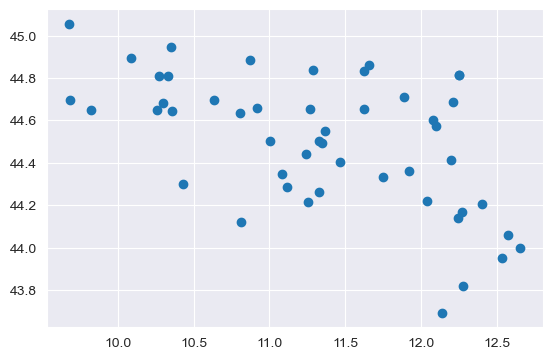

In [48]:
gdf.plot()

In [49]:
gdf.to_file('Storico meteo/Processed_data/wind_stations.shp')

In [59]:
interpolated_data.to_csv('Storico meteo/Processed_data/wind_stations_variables.csv')